<a href="https://colab.research.google.com/github/cheenu1025/capstone_project/blob/main/capstone_pneumonia_detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AIML Online Capstone - Pneumonia Detection Challenge:**

What is Pneumonia?
**bold text**
Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli.

Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2017, 920,000 children under the age of 5 died from the disease. It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or postradiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.

CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.

**Pneumonia Detection**

Now to detection Pneumonia we need to detect Inflammation of the lungs. In this project, you’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

**Business Domain Value:**

Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box.

Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology).
Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

**Project Description:**

In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image.

Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.

While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

Details about the data and dataset files are given in below link,

https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data


In [1]:
# Mount Google Drive and loading the necessary libraries

%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

#Initialize the random number generator
import random as rd
rd.seed(0)
#Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt

from google.colab import drive  # import drive from google colab
drive.mount('/content/drive',force_remount=True)  # default location for the drive
os.chdir("/content/drive/My Drive/CV/CapstoneProject/") # we mount the google drive at /content/drive and change dir to this.

2.8.2
Mounted at /content/drive


In [2]:
# Reading the train labels dataset and showing first 5 records of this train labels
data= pd.read_csv ("rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
data.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


#Insights of info: 

*    Train dataset comprises of 30227 patients details but coordinates of bounding boxes are given

*   Only for 9555 patients

*    Hence remaining are considered as null values



In [4]:
data.shape

(30227, 6)

In [5]:
# Detecting missing values

data.isnull().sum()

# below data reflects that 20672 chest x rays having null values and dont have any bounding boxes 

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

In [6]:
# counting the Target those having chest X rays with out bounding boxes 

data[data.isnull().any(axis=1)].Target.value_counts()

0    20672
Name: Target, dtype: int64

In [7]:
# counting the Target those having chest X rays with bounding boxes

data[~data.isnull().any(axis=1)].Target.value_counts()

1    9555
Name: Target, dtype: int64

In [8]:
data[data.isnull().any(axis=1)]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
30216,c1cf3255-d734-4980-bfe0-967902ad7ed9,NaN,NaN,NaN,NaN,0
30217,c1e228e4-b7b4-432b-a735-36c48fdb806f,NaN,NaN,NaN,NaN,0
30218,c1e3eb82-c55a-471f-a57f-fe1a823469da,NaN,NaN,NaN,NaN,0
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0


# insights of null values: 

*   It has been found that 20672 patients with target 0- dont have pnemonia (chest X rays with out bounding boxes)

*   9555 patients with target 1- having pnemonia (chest X rays with bounding boxes)



In [9]:
# checking if there are unique values of patient ID

data["patientId"].is_unique

False

In [10]:
# checking the duplicate patient ids because corrdinates of bounding boxes might be duplicates

data["patientId"].duplicated().sum()

3543

In [11]:
duplicatept= data[data["patientId"].duplicated()]

In [12]:
duplicatept.head(5)

,patientId,x,y,width,height,Target
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1
20,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1


In [13]:
# checking the duplicate patient ID has how many bounding boxes

data[data.patientId=="00704310-78a8-4b38-8475-49f4573b2dbb"]

,patientId,x,y,width,height,Target
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [14]:
data[data.patientId=="00c0b293-48e7-4e16-ac76-9269ba535a62"]

,patientId,x,y,width,height,Target
16,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1


  <b> 

*   From the above examples, it indicates that same patient has 2 bounding boxes in their DICOM images



In [15]:
# checking the count of Target column
data.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [16]:
# Reading the detailed class info

det_class= pd.read_csv(("rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv"))
det_class.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [17]:
# checking the shape
det_class.shape

(30227, 2)

In [18]:
# checking the info
det_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [19]:
# checking the null values
det_class.isnull().sum()

patientId    0
class        0
dtype: int64

In [20]:
# checking the duplicate values

det_class.patientId.duplicated().sum()

3543

* <b>it indicates that same number of patient ID s are duplicate as like in train label dataset

In [21]:
# checking the duplicate patients 
duplicate_class= det_class[det_class.patientId.duplicated()]
duplicate_class.head(5)

,patientId,class
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
15,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
20,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity


In [22]:
# checking the duplicate patients with their respective classes

det_class[det_class.patientId=="00704310-78a8-4b38-8475-49f4573b2dbb"]

,patientId,class
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [23]:
det_class[det_class.patientId=="00c0b293-48e7-4e16-ac76-9269ba535a62"]

,patientId,class
16,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity


In [24]:
# checking the count of class column

det_class["class"].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

Lets check the distribution of `Target` and `class` column
--------------------------------------------------------------------------------


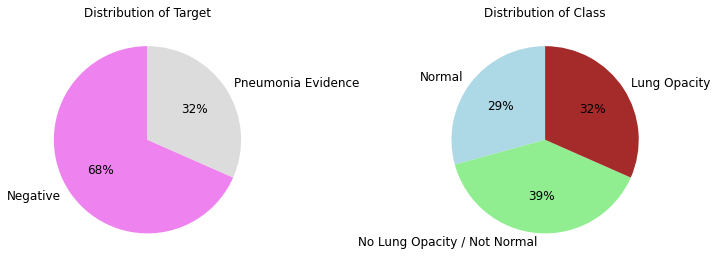

In [25]:
print('Lets check the distribution of `Target` and `class` column'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (data['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['violet', 'gainsboro'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (det_class['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['lightblue', 'lightgreen', 'brown'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()


In [26]:
print('Let\'s group by patient IDs and check number of bounding boxes for each unique patient ID');print('--'*44)
b_boxes = data.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
data = data.merge(b_boxes, on = 'patientId', how = 'left')
print('Number of unique patient IDs in the dataset: {}'.format(len(b_boxes)))
print('\nNumber of patient IDs per b_boxes in the train dataset')
(b_boxes.groupby('number_of_boxes')
.size()
.to_frame('number_of_patientIDs_per_boxes')
.reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))


Let's group by patient IDs and check number of bounding boxes for each unique patient ID
----------------------------------------------------------------------------------------
Number of unique patient IDs in the dataset: 26684

Number of patient IDs per b_boxes in the train dataset


,number_of_patientIDs_per_boxes
number_of_boxes,
1,23286
2,3266
3,119
4,13


In [27]:
# Merging the data in two csv into one.
train_data = data.merge(det_class, left_on='patientId', right_on='patientId', how='inner')
train_data.head()

,patientId,x,y,width,height,Target,number_of_boxes,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity


In [28]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# analysing the stage 2 train images (DICOM format)
import pydicom as dcm
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patches as patches


def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = 'rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

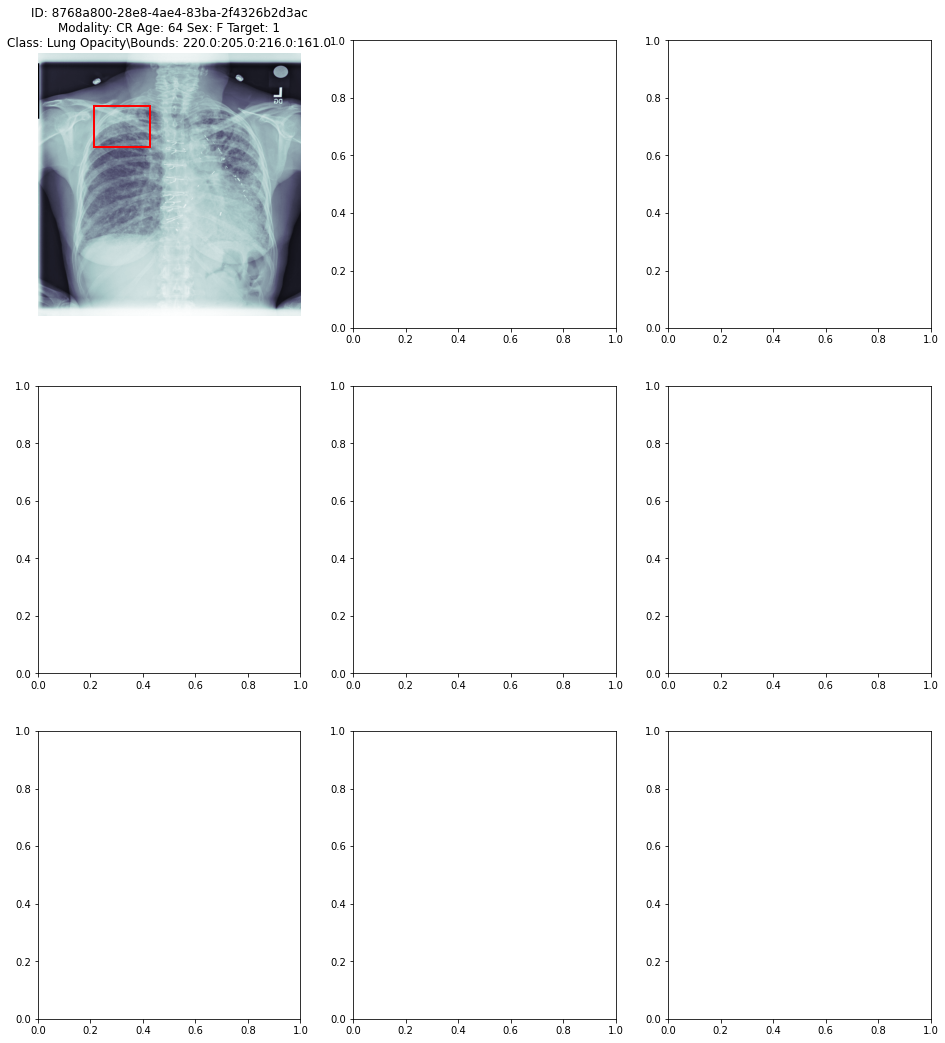

In [31]:
## checking few images which has pneumonia 

inspectImages(train_data[train_data['Target']==1].sample(1))

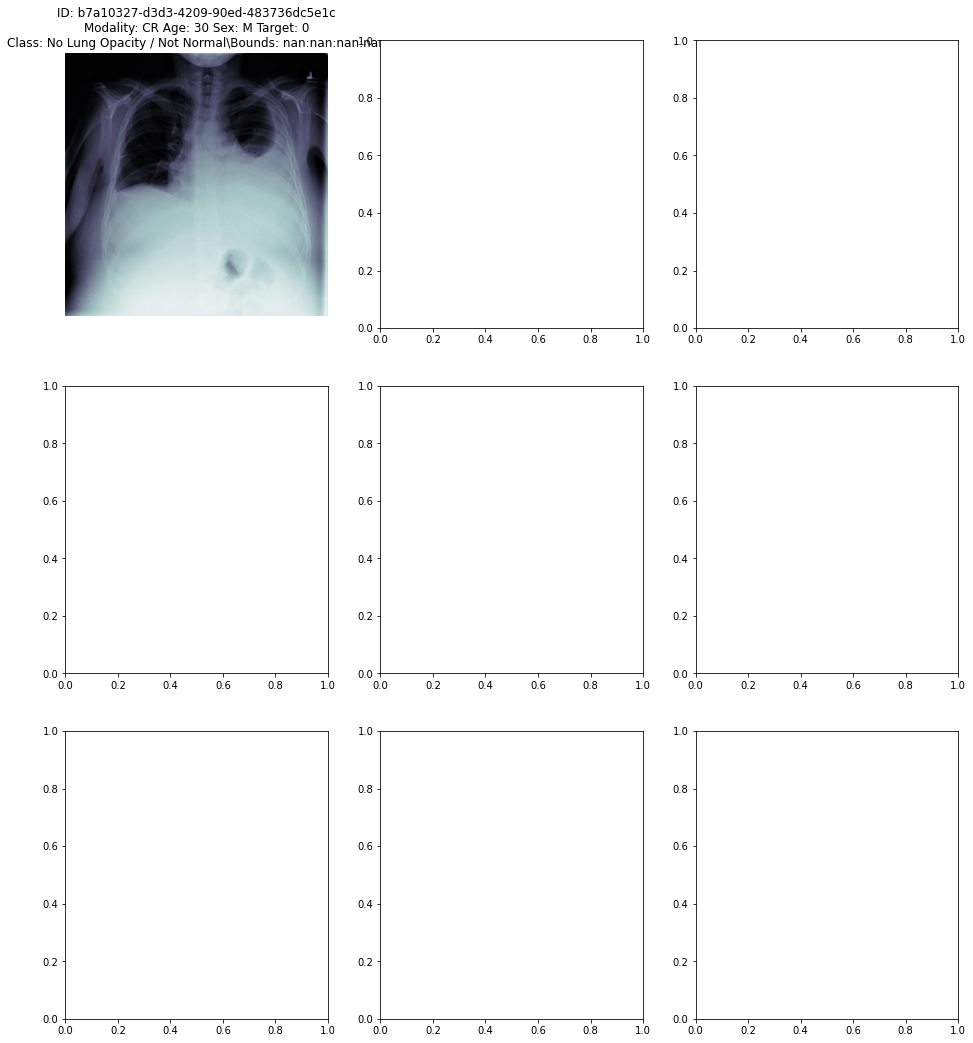

In [32]:
## checking few images which does not have pneumonia 
inspectImages(train_data[train_data['Target']==0].sample(1))



# Reading the Dicom images meta data and appending it to the training set

In [ ]:
## DCIM image also being included with the meta data, 
## Function to read the dcim data and appending to the resultset
def readDCIMData(rowData):
    dcm_file = 'rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

In [ ]:
## Reading the image data and append it to the training_data dataset
train_data['sex'], train_data['age'] = zip(*train_data.apply(readDCIMData, axis=1))

In [ ]:
train_data.info()

* <b> From the above info it was clear that sex and age of the patient dont have any null values

In [ ]:
# Converting age to Numeric as the current data type is a String
train_data['age'] = train_data.age.astype(int)

In [ ]:
train_data.describe(include="all")

# Observations of age:
   * <b>The mean age is 46 years , where as minimum age is 1 year and the maximum age is 155 which seems to be an outlier
   * <b>50% of the patiens are of around 49 age , the std deviation is 16 which suggest that age is not normally distributed

In [ ]:
## Distribution of Target

label_count=train_data['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', startangle=90)
ax1.axis('equal') 
plt.title( "Distribution of Target")
plt.show()

# insights:
 * <b> There are 31% of patients with pneumonia and the remaining are of no pneumonia
 * <b> This indicates that there is a class imbalance issue

In [ ]:
## Distribution of Classes

class_count=train_data['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.pie(class_count.values, explode=explode, labels=class_count.index, autopct='%1.1f%%', 
        startangle=90)
ax1.axis('equal')
plt.title('Distribution of Class')
plt.show()

# insights: 
* <b> There are 39% of patients with No Lung opacity , 
* <b> 29.3% Normal and 
* <b> the remaining are with Lung Opacity

In [ ]:
# insights: 
# there are 39% of patients with No Lung opacity , 
# 29.3% Normal and 
# the remaining are with Lung Opacity

In [ ]:
# distribution of target and class

fig, ax = plt.subplots(nrows = 1, figsize = (8, 6))
temp = train_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'tab10')
plt.title('Class and Target  Distrubution')

# insights:

* <b> Target 0 has only Normal or No Lung Opacity class
* <b> Target 1 has only Lung Opacity class

In [ ]:
# count of gender
train_data.sex.value_counts()

In [ ]:
# Distbution of Sex among the targets
fig, ax = plt.subplots(nrows = 1, figsize = (8, 5))
temp = train_data.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'pastel')
plt.title('Sex and Target for Chest Exams')

# Insights:
 * <b> The number of males in both category are higher than women

In [ ]:
# # Distbution of Sex among the classes

fig, ax = plt.subplots(nrows = 1, figsize = (8, 5))
temp = train_data.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

# Insight:
* <b> The number of males in all classes are higher than women

In [ ]:
# plot of age distribution
# dist plot
sns.distplot(train_data.age) 

In [ ]:
# Distribution of PatientAge who have pneumonia

sns.distplot(train_data.loc[train_data['Target'] == 1, 'age'])

In [ ]:
# Subplots

fig = plt.figure(figsize = (12, 4))

ax = fig.add_subplot(121)
g = (sns.distplot(train_data['age']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(train_data.loc[train_data['Target'] == 1, 'age']).set_title('Distribution of PatientAge who have pneumonia'))

In [ ]:
# distribution of Age among target

# Bar plot

sns.barplot(x='Target', y='age', data=train_data)

# Insight: 

* <b> Patients of around 45 years age are of with target class 1( having pnemonia)

In [ ]:
# Distribution of Age among class

# Bar plot
 
sns.barplot(x='class', y='age', data=train_data) 

# insight: 

* <b> Patients of around 45 years age are having lung opacity(pnemonia)

In [ ]:
# Box plot

plt.figure(figsize= (10,5))
sns.boxplot (x= "class", y= "age", data= train_data)

# Insight of box plot:
* <b> The  class which has no pneuomia has few outliers , their age is somewhere aroun 150 years

In [ ]:
# corrrelation matrix
corr_mat = train_data.corr()
plt.figure(figsize=(12,5))

sns.heatmap(corr_mat,annot=True)